### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])
df['Duration_Category'].value_counts()

Duration_Category
11.0–14.0 hrs    649
20.8+ hrs        558
9.5–11.0 hrs     525
2.8–9.5 hrs      395
0–2.8 hrs        114
14.0–20.8 hrs     30
Name: count, dtype: int64

### Function for model training 

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def train_rf_model(df, params=None, fine_tune=False, test_size=0.2, random_state=42):
    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical columns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    model = RandomForestClassifier(random_state=random_state)

    if params is not None:
        # If params are passed, use those for the model
        print(f"Using provided parameters: {params}")
        model = RandomForestClassifier(random_state=random_state, **params)
        model.fit(X_train, y_train)
    elif fine_tune:
        # --- Fine-tuning with GridSearchCV (only if fine_tune=True and params are not provided)
        print("Performing GridSearchCV to find the best parameters...")
        param_grid = {
            'n_estimators': [50, 100, 150],  # Number of trees in the forest
            'max_depth': [None, 10, 20, 30],  # Depth of the trees
            'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
            'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
            'bootstrap': [True, False]  # Whether bootstrap samples are used
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                   cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Get the best model from grid search
        model = grid_search.best_estimator_
        print("Best Hyperparameters from GridSearchCV:", grid_search.best_params_)

    else:
        # If no params and no fine_tuning, just train with default RandomForest parameters
        print("Training with default RandomForest parameters...")
        model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test

### Import function for model evaluation

In [4]:
from data.functions.eval_model import evaluate_rf_model

# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# def evaluate_rf_model(model, X_train, X_test, y_train, y_test, full_label_order=None):
#     # If full_label_order is not provided, use default
#     if full_label_order is None:
#         full_label_order = [
#             '0–2.8 hrs',
#             '2.8–9.5 hrs',
#             '9.5–11.0 hrs',
#             '11.0–14.0 hrs',
#             '14.0–20.8 hrs',
#             '20.8+ hrs'
#         ]
    
#     # --- 5. Predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # --- 6. Accuracy
#     train_acc = accuracy_score(y_train, y_train_pred)
#     test_acc = accuracy_score(y_test, y_test_pred)

#     # --- 7. Get present labels (classes that actually exist)
#     present_labels = full_label_order

#     # --- 8. Classification Report
#     print("Classification Report (Test Set):")
#     print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

#     # --- 9. Visualization (Feature Importances, Confusion Matrices, and Distributions)
#     fig = plt.figure(figsize=(18, 16))
#     gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1]) 

#     # --- Feature Importances
#     ax0 = fig.add_subplot(gs[0, :])
#     importances = model.feature_importances_
#     indices = np.argsort(importances)[::-1]
#     feature_names = X_train.columns

#     ax0.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
#     ax0.invert_yaxis()
#     ax0.set_title("Feature Importances")
#     ax0.set_xlabel("Importance")

#     # --- Confusion Matrices (Include all classes, even those with 0 occurrences)
#     cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
#     cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

#     ax1 = fig.add_subplot(gs[1, 0])
#     disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
#     disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
#     ax1.set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

#     ax2 = fig.add_subplot(gs[1, 1])
#     disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
#     disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
#     ax2.set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

#     # --- Duration Category Distributions (Show all classes, even if count is 0)
#     train_categories = y_train.value_counts().sort_index()
#     test_categories = y_test.value_counts().sort_index()

#     # Ensure all classes are included, even if count is 0
#     train_counts = train_categories.reindex(full_label_order, fill_value=0)
#     test_counts = test_categories.reindex(full_label_order, fill_value=0)

#     ax3 = fig.add_subplot(gs[2, 0])
#     ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
#     ax3.set_title("Train Set Duration Category Distribution")
#     ax3.set_xlabel("Duration Category")
#     ax3.set_ylabel("Count")
#     ax3.tick_params(axis='x', rotation=45)

#     ax4 = fig.add_subplot(gs[2, 1])
#     ax4.bar(test_counts.index, test_counts.values, color='slateblue')
#     ax4.set_title("Test Set Duration Category Distribution")
#     ax4.set_xlabel("Duration Category")
#     ax4.set_ylabel("Count")
#     ax4.tick_params(axis='x', rotation=45)

#     plt.tight_layout()
#     plt.show()

In [5]:
# train model on all data, and fine tune it to find best params
model, X_train, X_test, y_train, y_test = train_rf_model(df, fine_tune=True)

Performing GridSearchCV to find the best parameters...
Best Hyperparameters from GridSearchCV: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.73      0.52      0.61        21
  2.8–9.5 hrs       0.85      0.67      0.75        83
 9.5–11.0 hrs       0.59      0.75      0.66       106
11.0–14.0 hrs       0.76      0.73      0.74       126
14.0–20.8 hrs       1.00      0.20      0.33         5
    20.8+ hrs       0.84      0.86      0.85       114

     accuracy                           0.74       455
    macro avg       0.80      0.62      0.66       455
 weighted avg       0.76      0.74      0.74       455



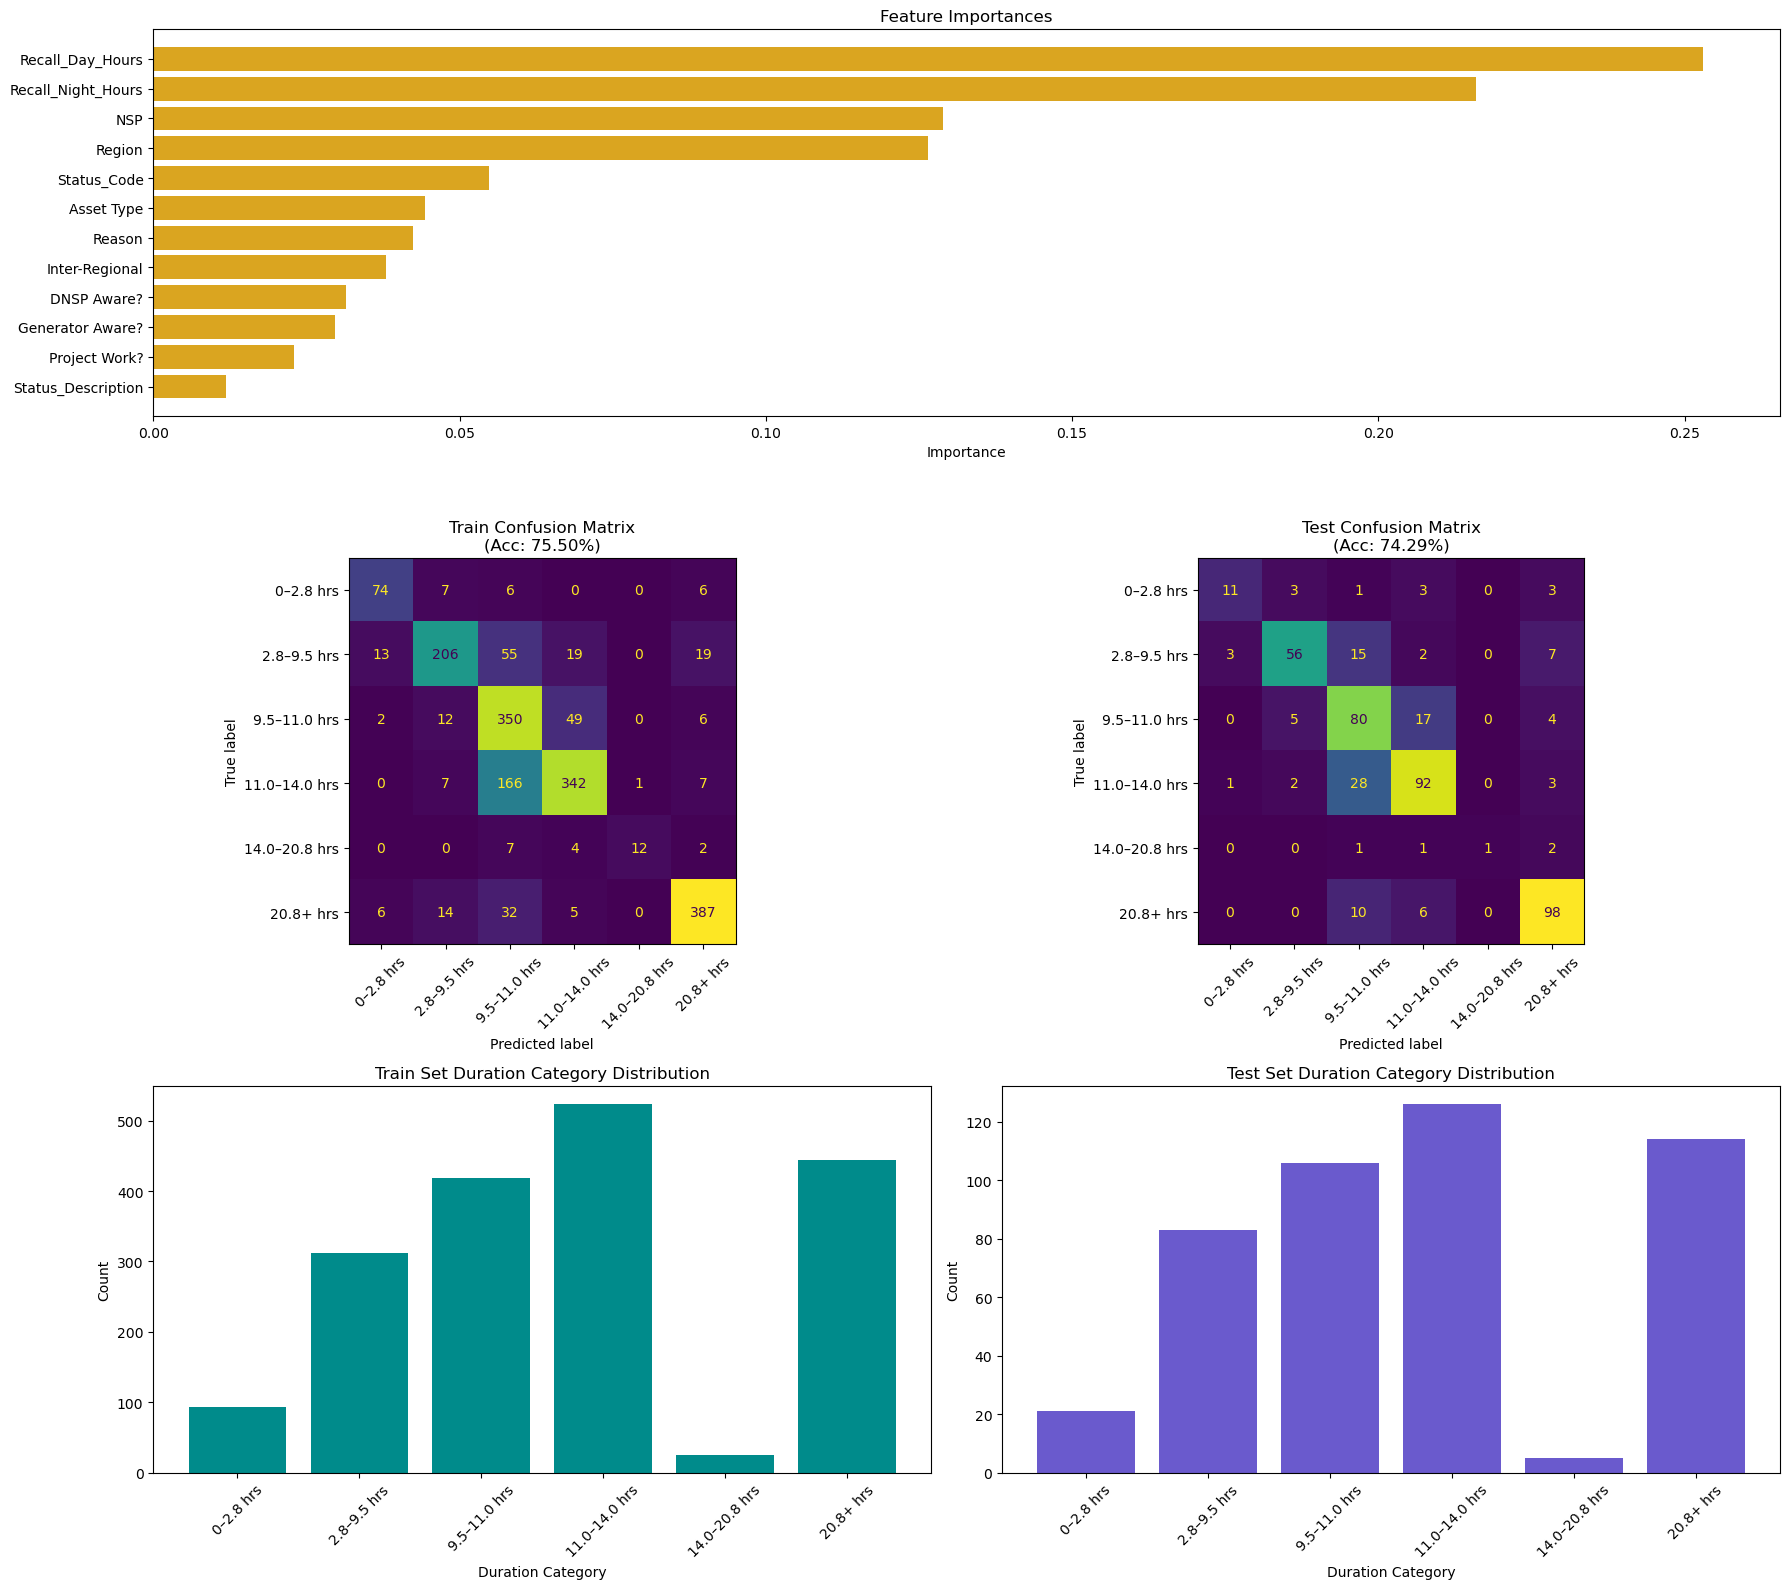

In [6]:
evaluate_rf_model(model, X_train, X_test, y_train, y_test)

### Model fitting on state-specific data

--- Region: SA ---
Using provided parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       1.00      1.00      1.00         3
  2.8–9.5 hrs       0.50      0.62      0.56         8
 9.5–11.0 hrs       0.00      0.00      0.00         1
11.0–14.0 hrs       0.67      0.50      0.57         4
14.0–20.8 hrs       1.00      0.50      0.67         2
    20.8+ hrs       0.90      0.92      0.91        38

     accuracy                           0.82        56
    macro avg       0.68      0.59      0.62        56
 weighted avg       0.82      0.82      0.81        56



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


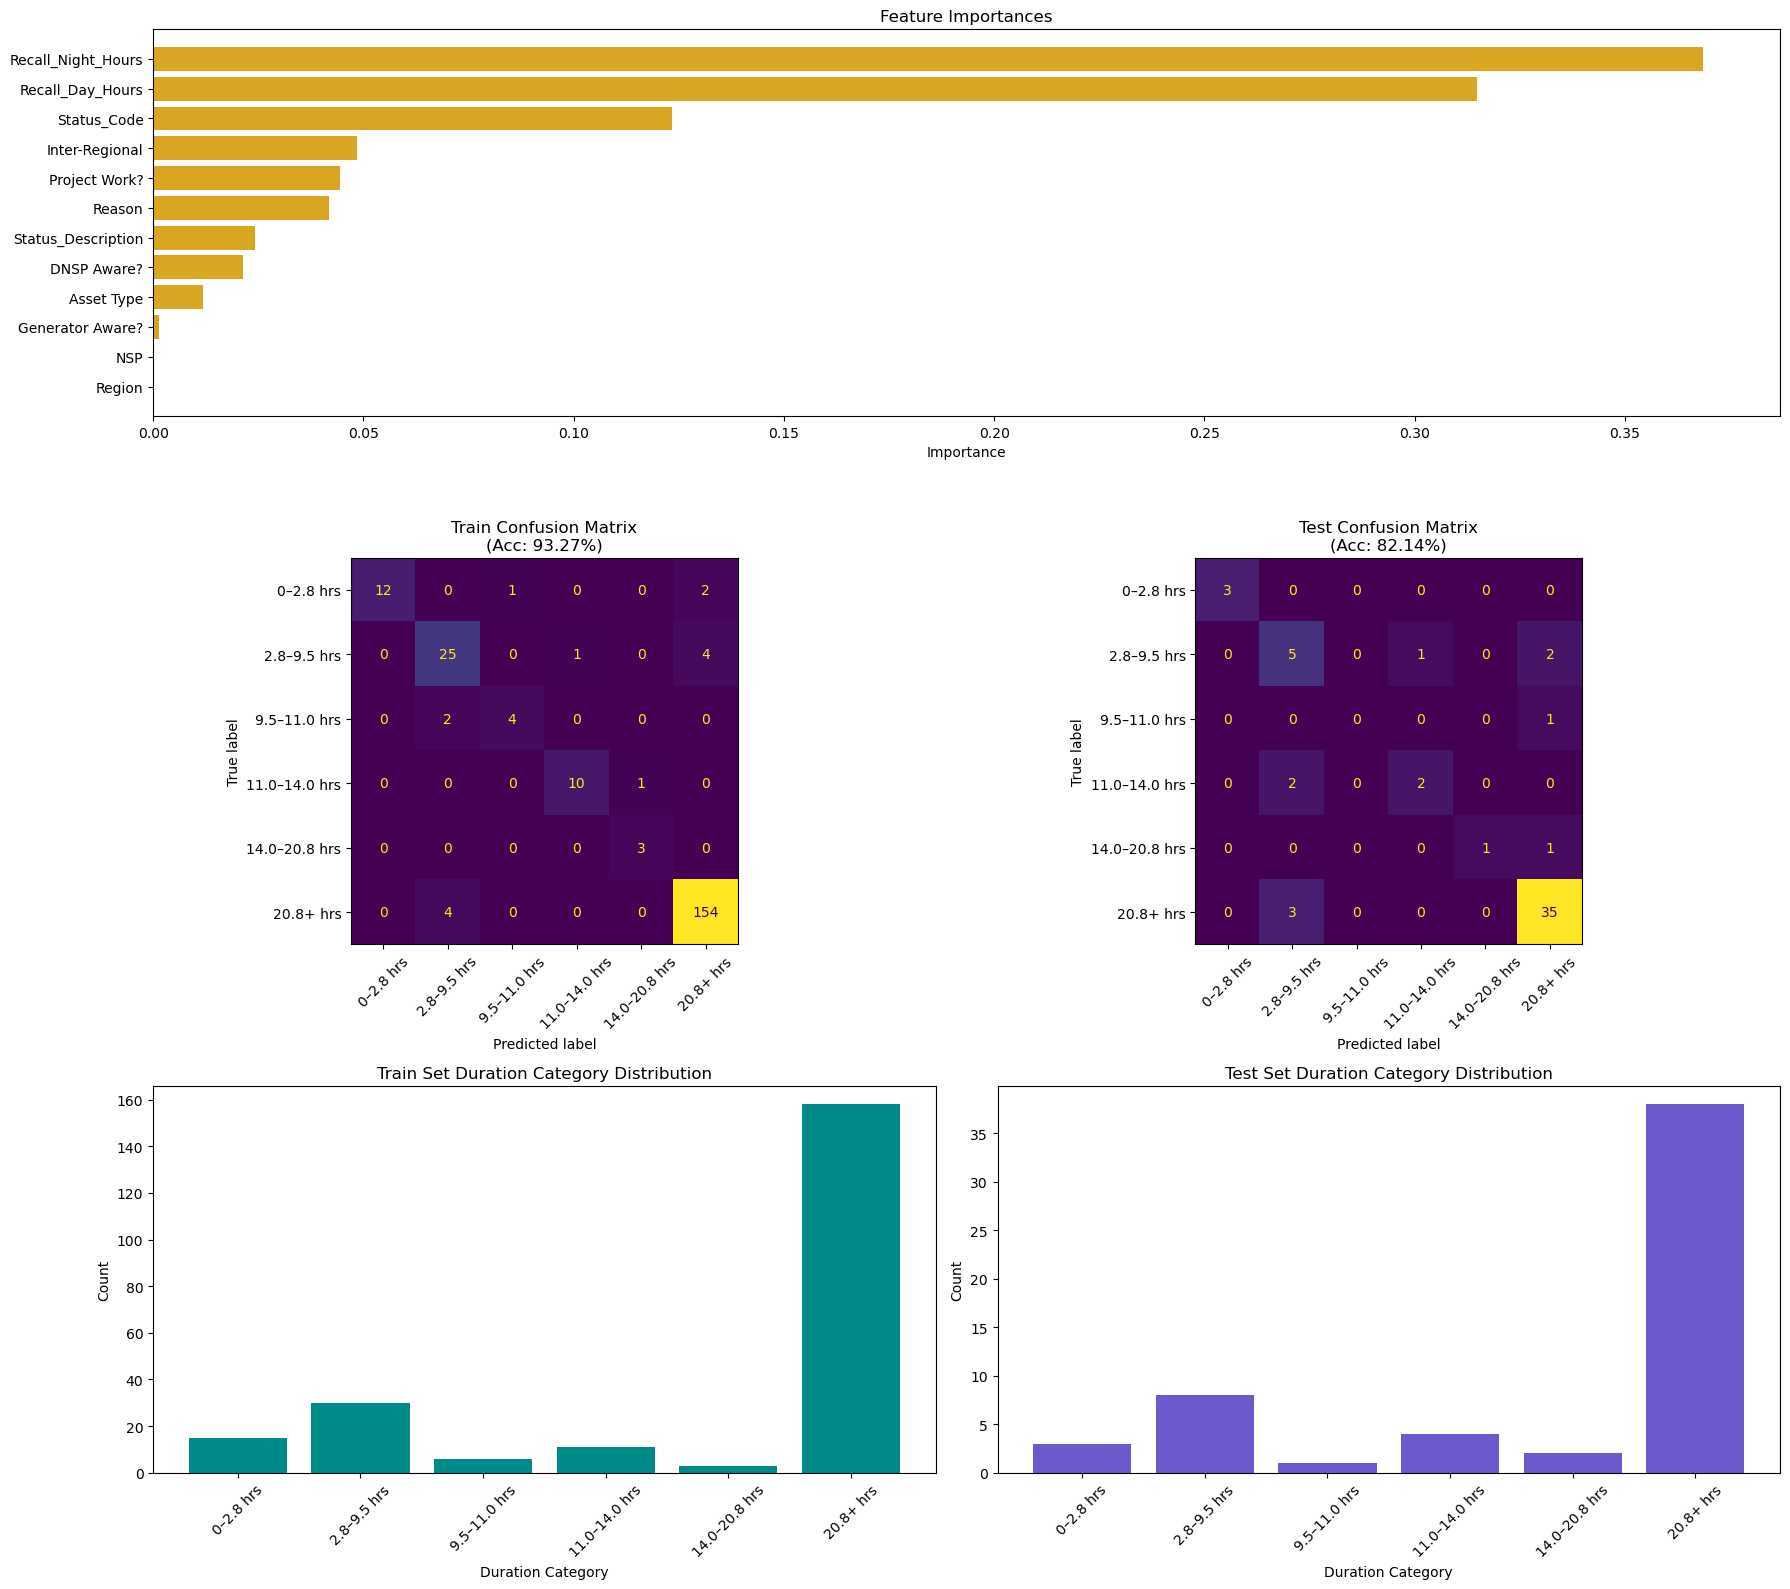

--- Region: VIC ---
Using provided parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.67      0.33      0.44         6
  2.8–9.5 hrs       0.67      0.21      0.32        19
 9.5–11.0 hrs       0.53      0.80      0.64        79
11.0–14.0 hrs       0.78      0.70      0.73       119
14.0–20.8 hrs       0.00      0.00      0.00         3
    20.8+ hrs       0.75      0.45      0.56        20

     accuracy                           0.65       246
    macro avg       0.57      0.41      0.45       246
 weighted avg       0.68      0.65      0.64       246



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


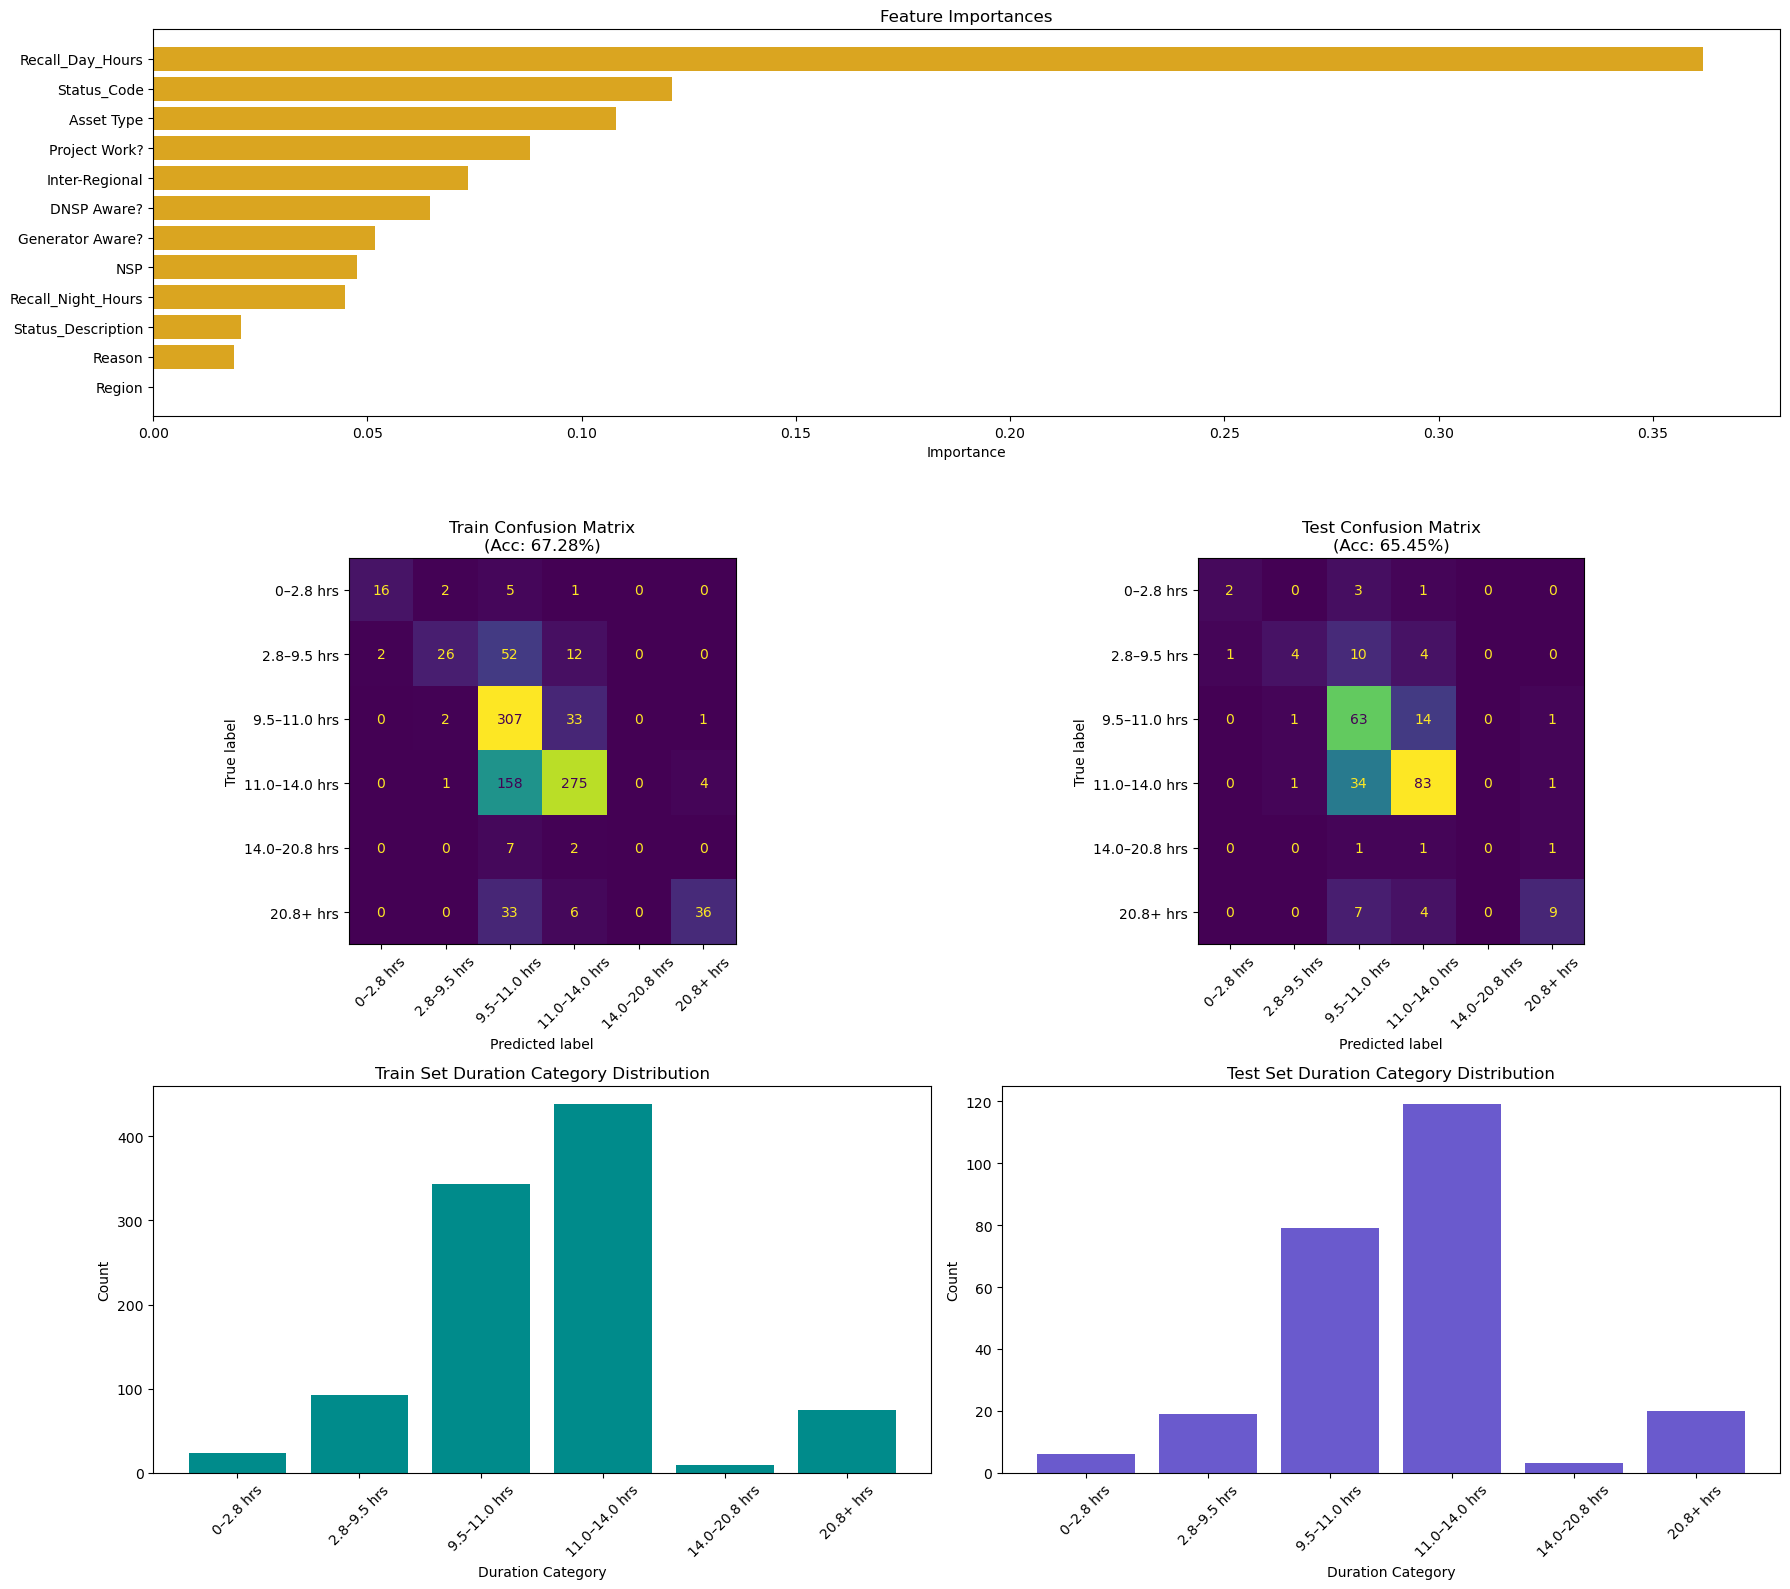

--- Region: TAS ---
Using provided parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.80      0.67      0.73         6
  2.8–9.5 hrs       0.75      0.86      0.80        14
 9.5–11.0 hrs       0.00      0.00      0.00         0
11.0–14.0 hrs       0.00      0.00      0.00         0
14.0–20.8 hrs       0.00      0.00      0.00         0
    20.8+ hrs       0.80      0.57      0.67         7

     accuracy                           0.74        27
    macro avg       0.39      0.35      0.37        27
 weighted avg       0.77      0.74      0.75        27



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/me

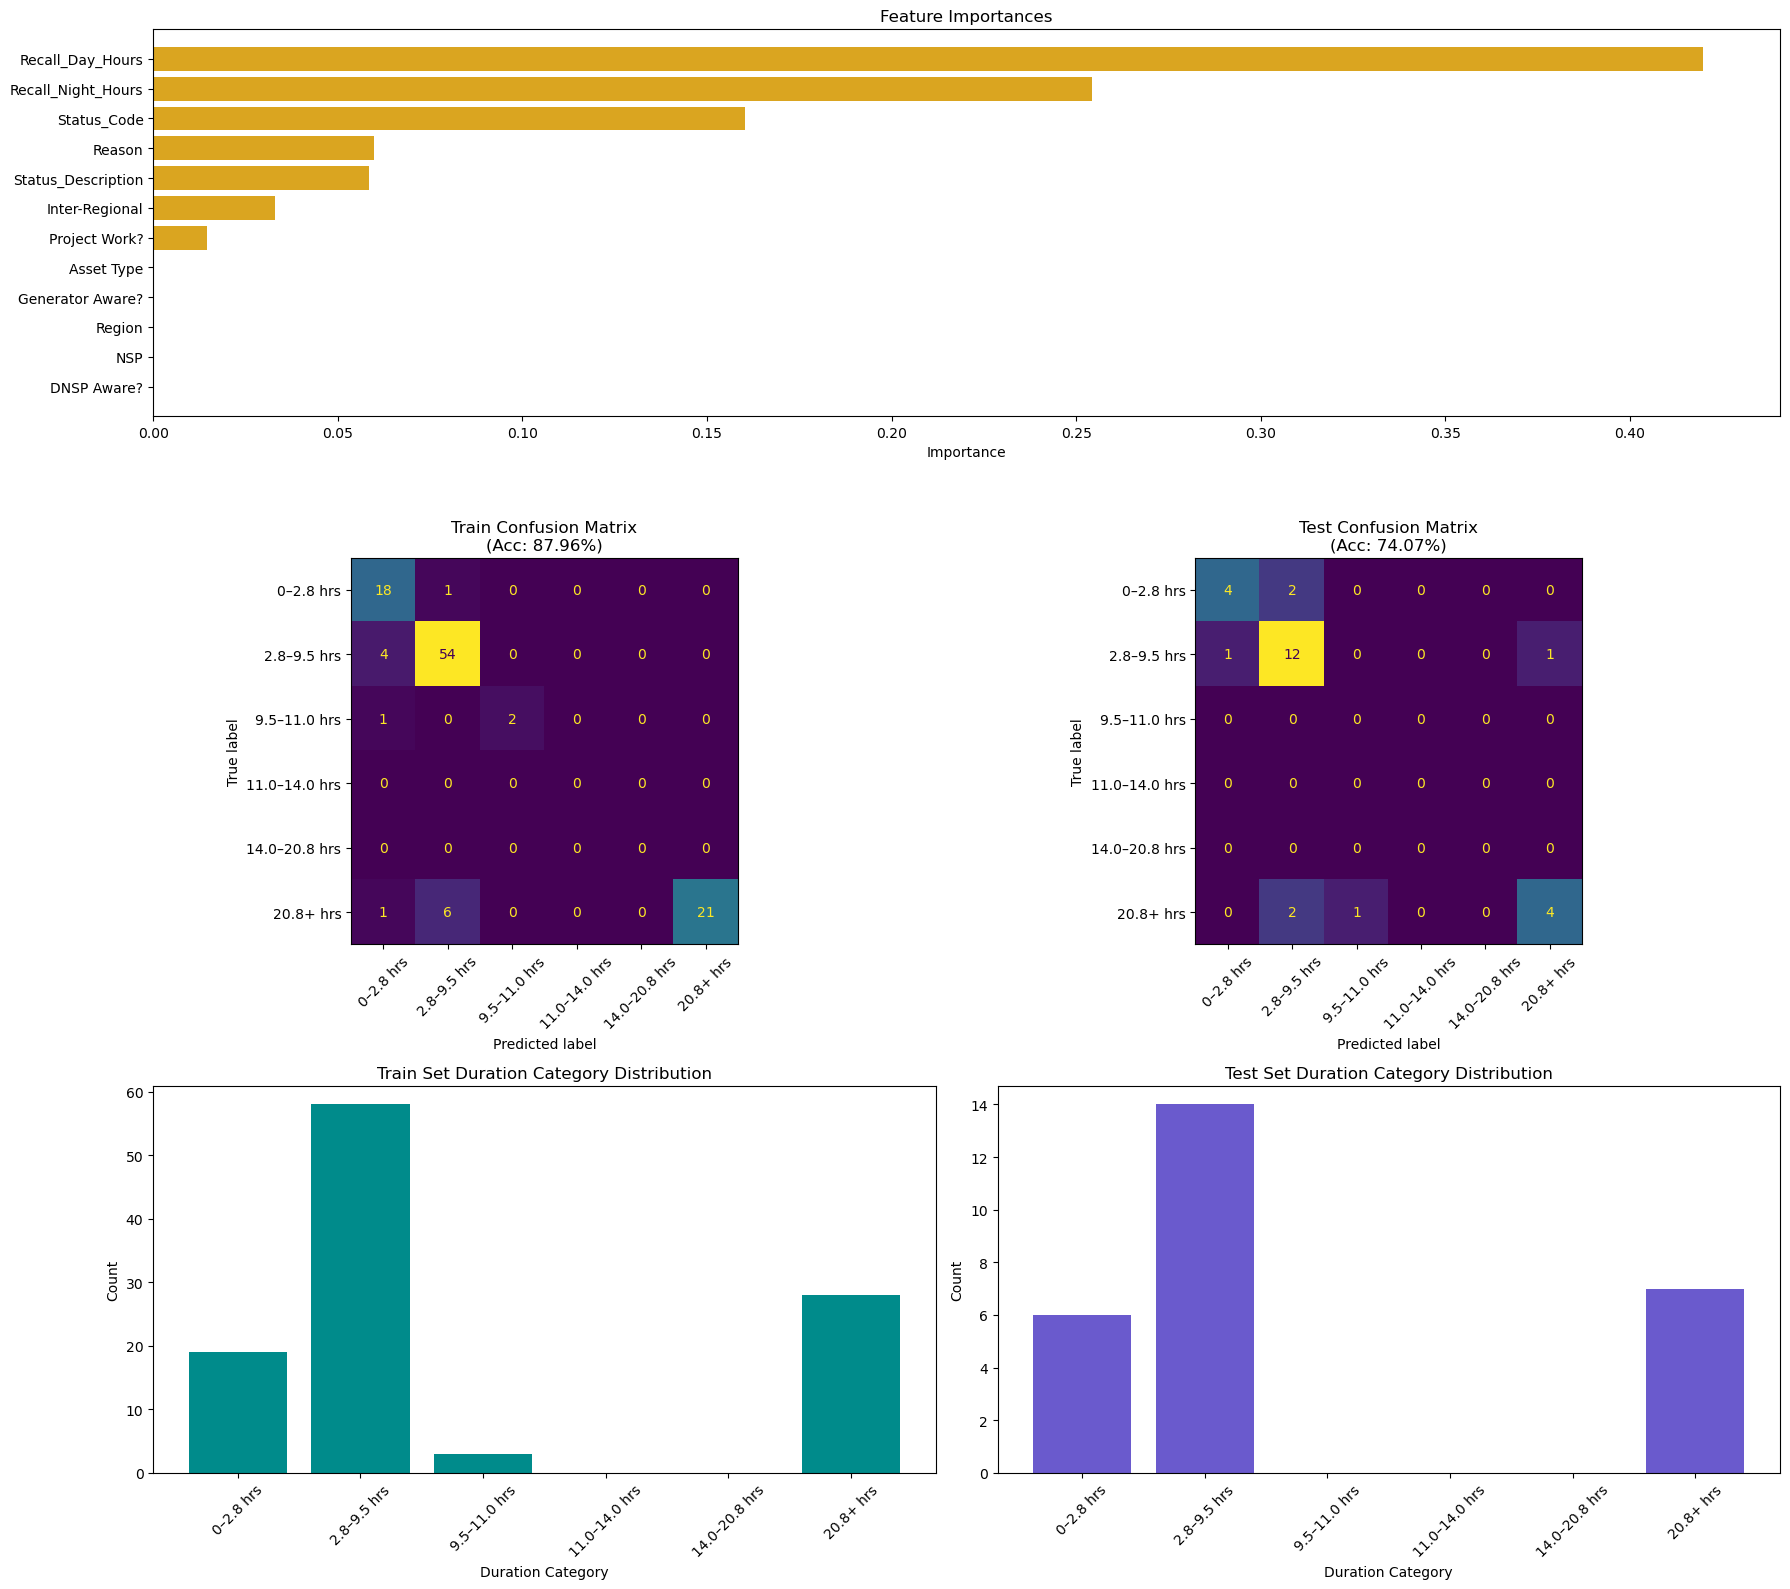

--- Region: QLD ---
Using provided parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.50      0.50      0.50         6
  2.8–9.5 hrs       0.96      0.79      0.87        34
 9.5–11.0 hrs       0.50      1.00      0.67         1
11.0–14.0 hrs       0.00      0.00      0.00         3
14.0–20.8 hrs       0.00      0.00      0.00         0
    20.8+ hrs       0.76      0.97      0.85        29

     accuracy                           0.81        73
    macro avg       0.45      0.54      0.48        73
 weighted avg       0.80      0.81      0.79        73



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/me

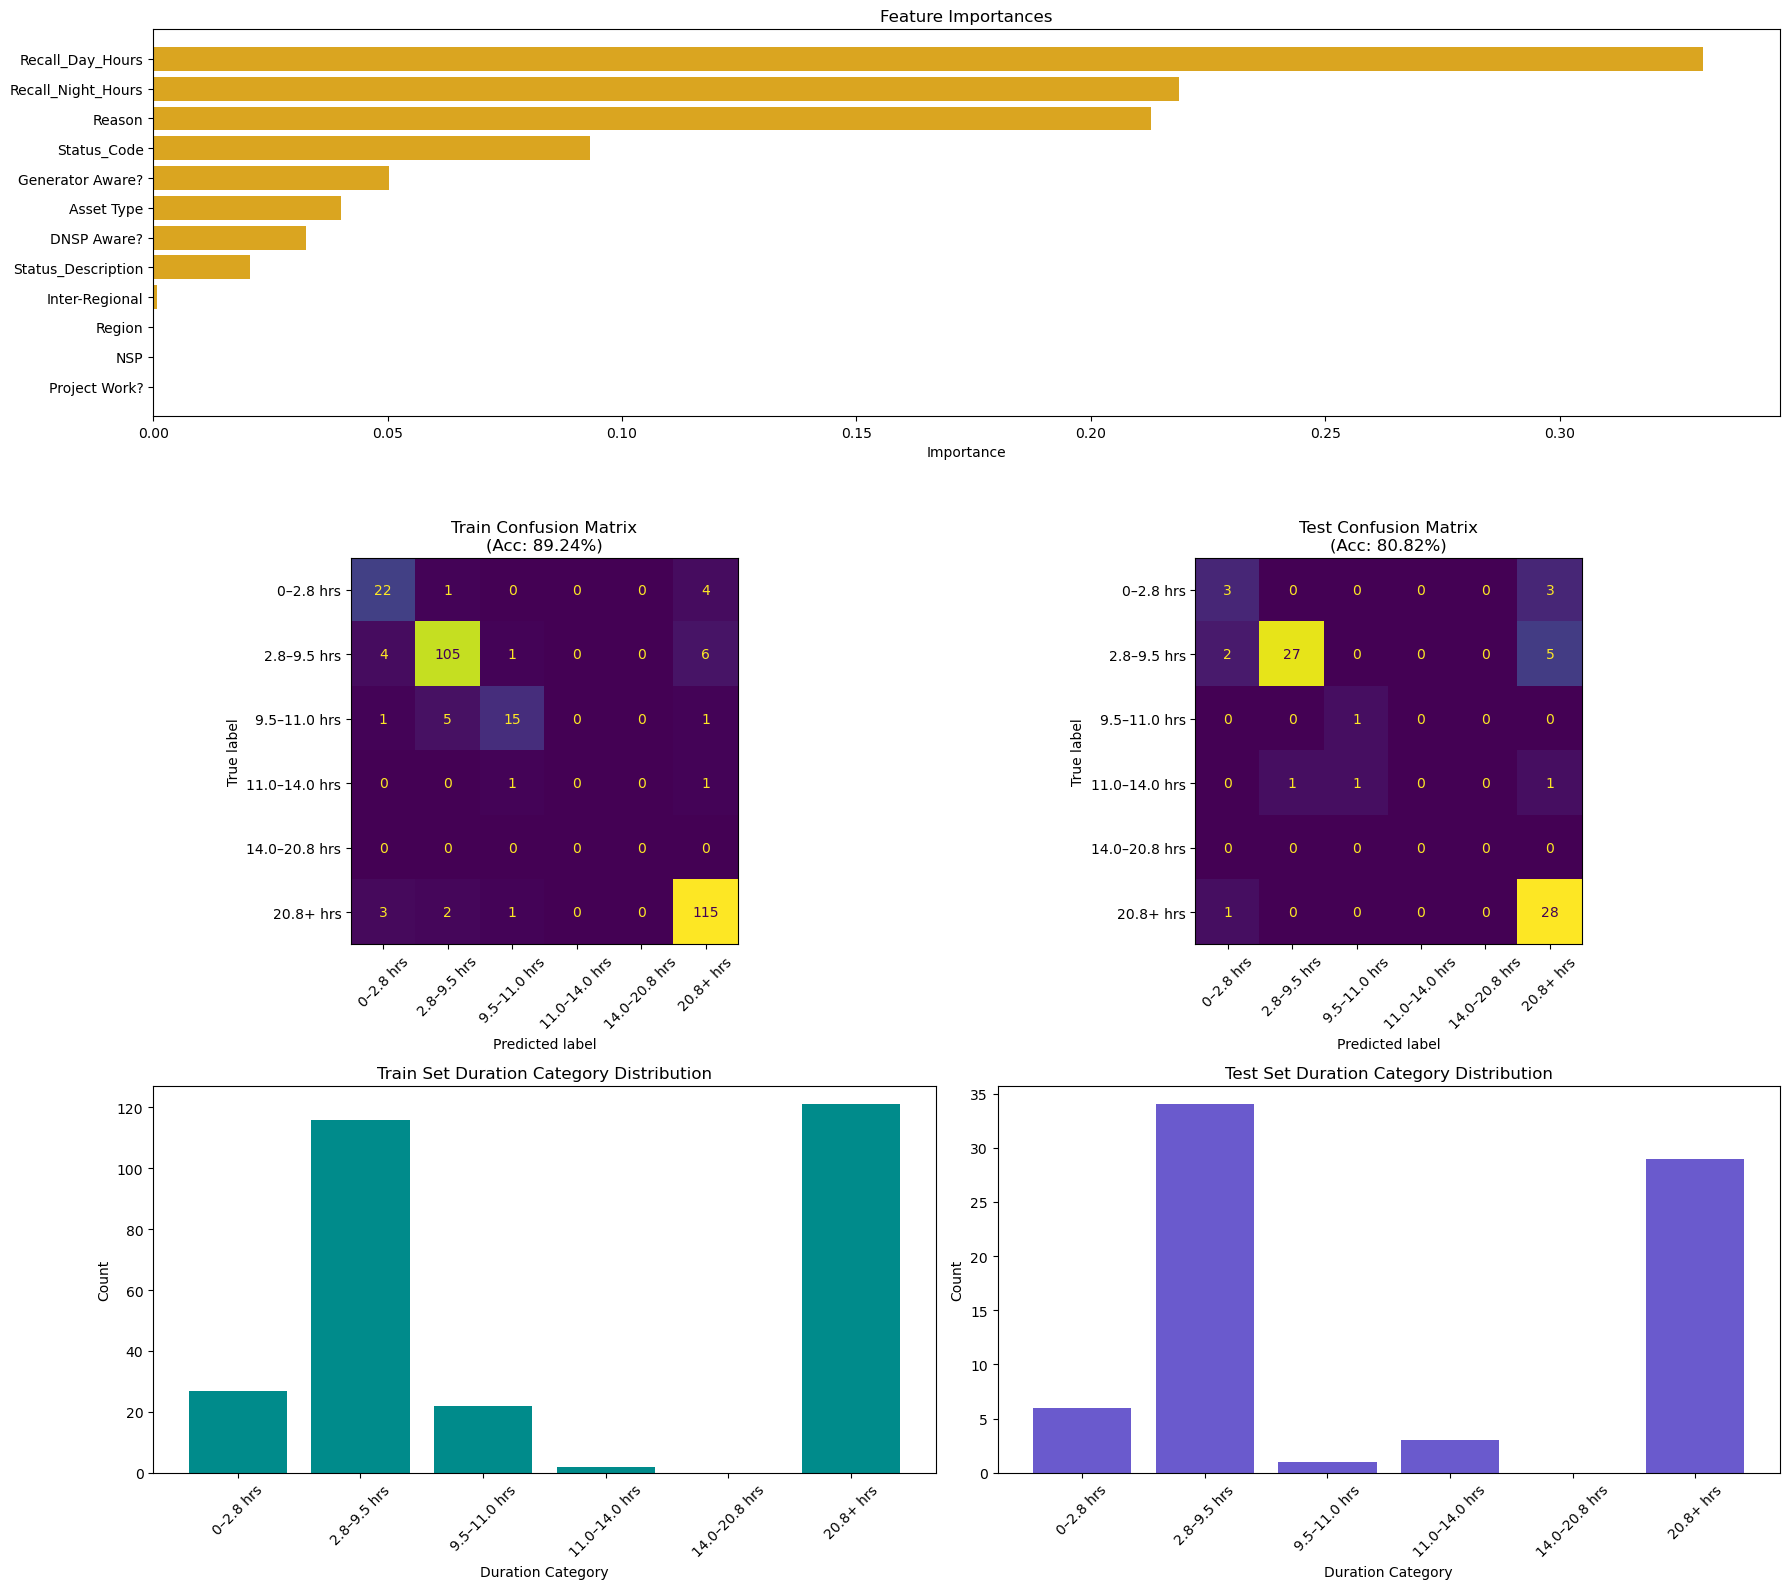

--- Region: NSW ---
Using provided parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.33      0.50      0.40         2
  2.8–9.5 hrs       0.00      0.00      0.00         5
 9.5–11.0 hrs       0.72      0.76      0.74        17
11.0–14.0 hrs       0.69      0.69      0.69        13
14.0–20.8 hrs       0.67      1.00      0.80         2
    20.8+ hrs       0.88      0.93      0.90        15

     accuracy                           0.72        54
    macro avg       0.55      0.65      0.59        54
 weighted avg       0.67      0.72      0.70        54



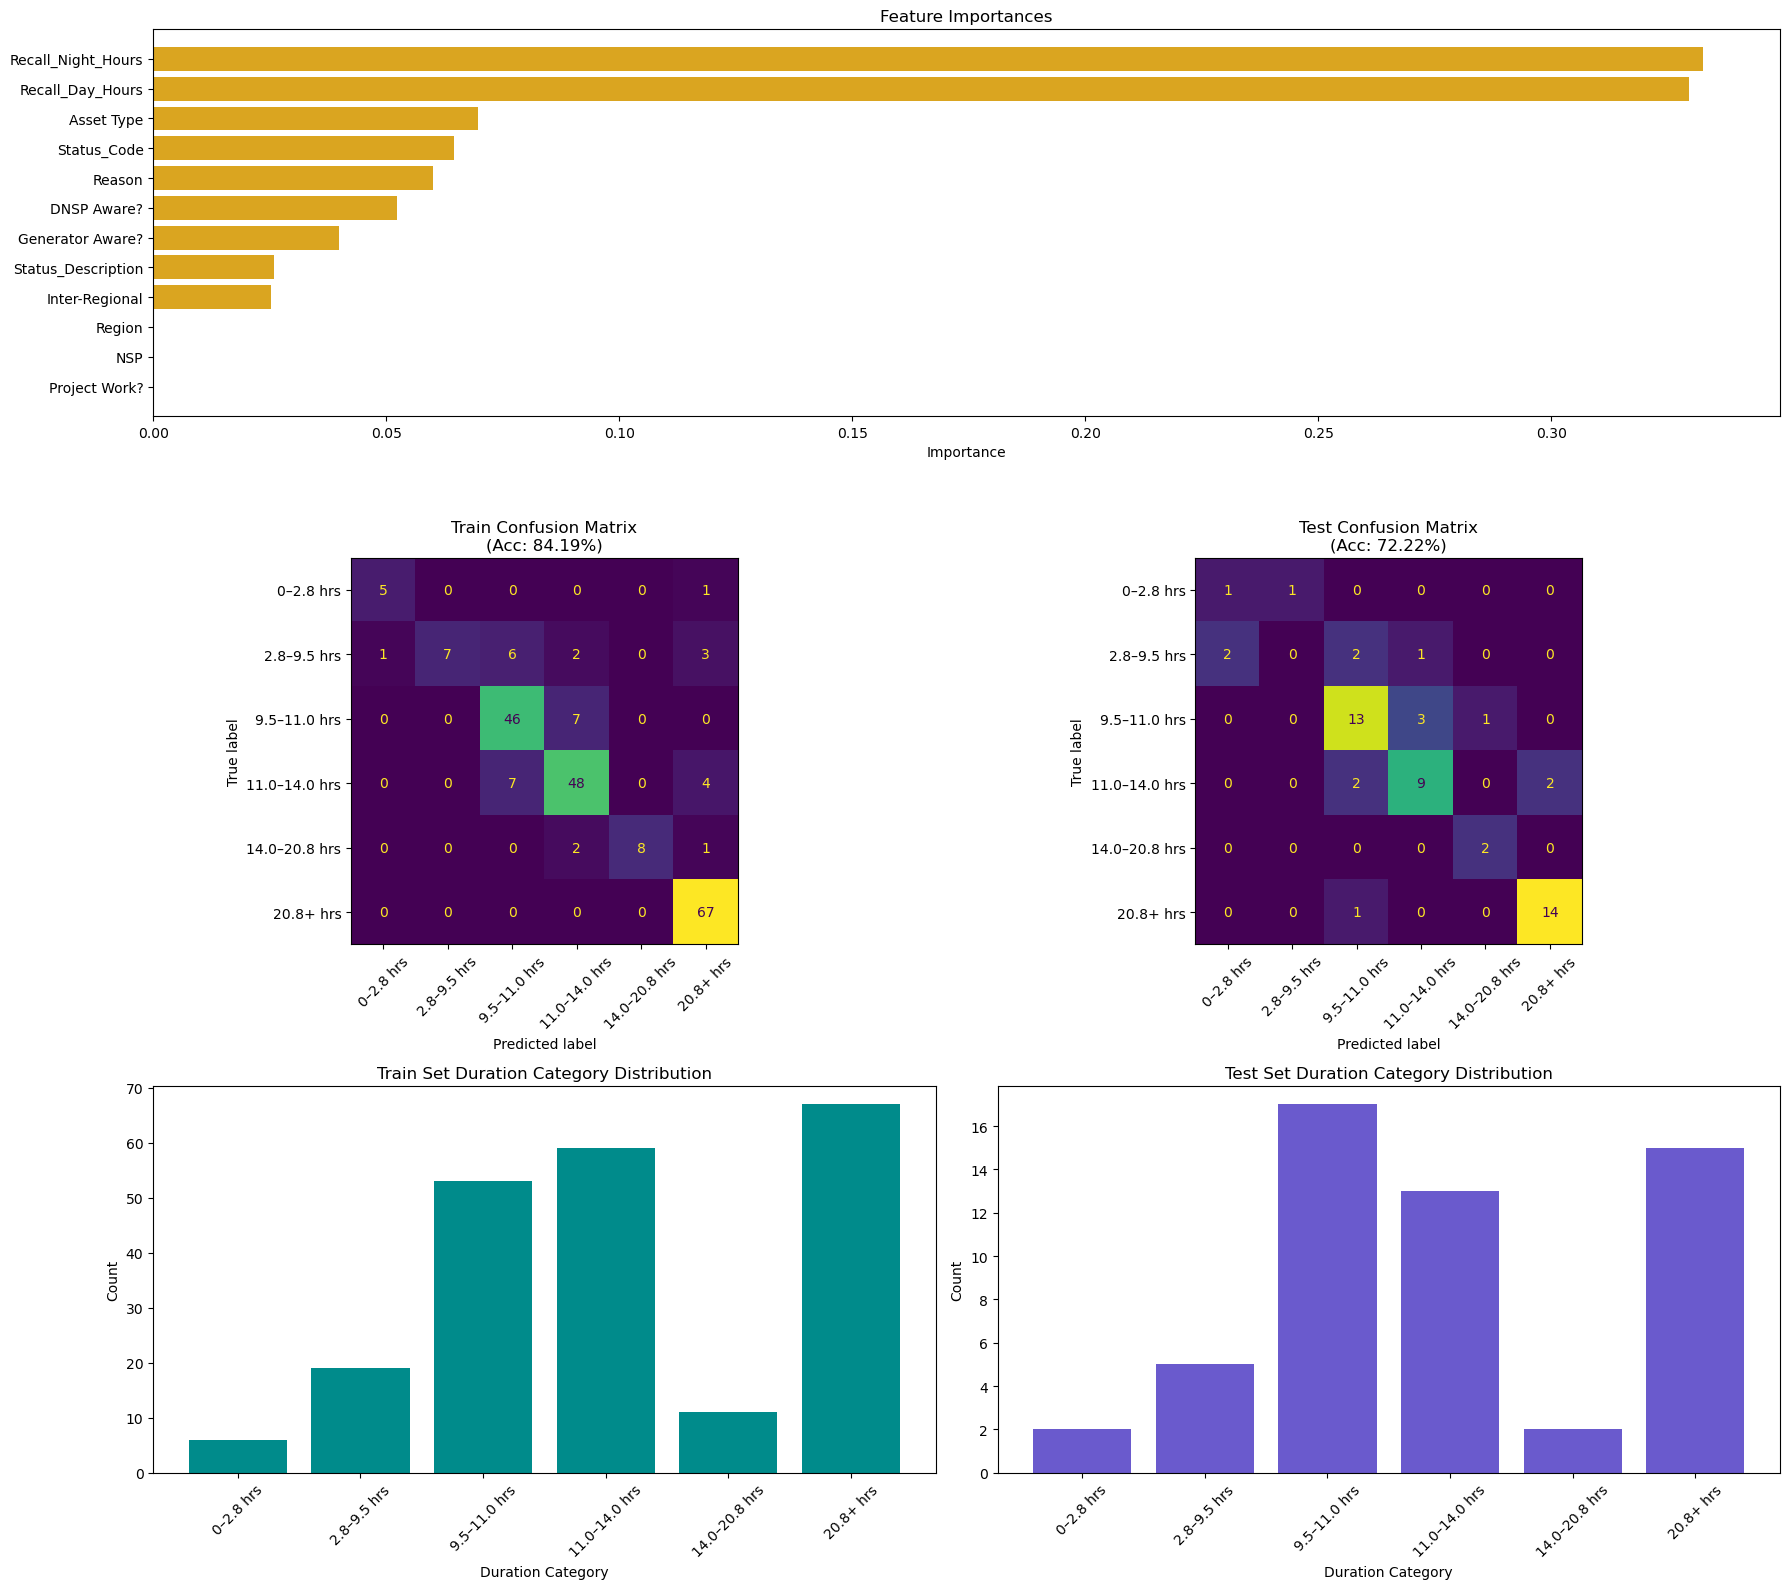

In [7]:
# Now, use the best hyperparameters to train models for each region
best_params = {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

# Dictionary to store models for each region
region_models = {}

# Loop through each unique region in the DataFrame
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    
    print(f"--- Region: {region} ---")
    
    # Train the model for the region
    model, X_train, X_test, y_train, y_test = train_rf_model(region_df, fine_tune=False, params=best_params)
    
    # Store the trained model for the region
    region_models[region] = model
    
    # Evaluate the model for the region
    evaluate_rf_model(model, X_train, X_test, y_train, y_test)
